In [ ]:
# 레이어 3개 모델
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [3]:
# 이전 파일과 다 똑같다. 
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

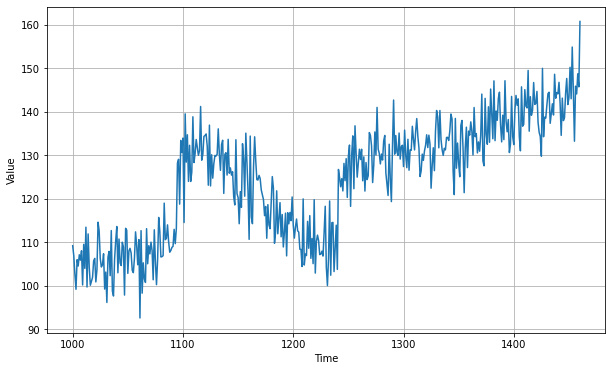

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    # 레이어가 3개
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)) # 컴파일
model.fit(dataset,epochs=100,verbose=0) # 훈련


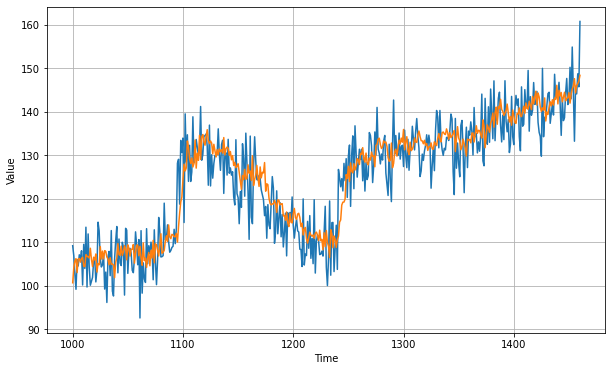

In [7]:
forecast = [] # 예측값 저장
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis])) # 원래 그래프를 window_size만큼 조각난 데이터를 이용해 예측

forecast = forecast[split_time-window_size:] # 예측 부분(검증 셋)만 가져옴
results = np.array(forecast)[:, 0, 0] #forecast를 넘파이로 만듬.


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.759273

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler( # 학습률에 따라 손실 정도가 다르다. 이를 기록하는 함수. 기록한걸 보고 학습률을 조정한 뒤 재학습을 한다.(최소 손실을 갖기 위해). 아래 코드에서 재학습 하는걸 확인할 수 있다. 
    lambda epoch: 1e-8 * 10**(epoch / 20)) 
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

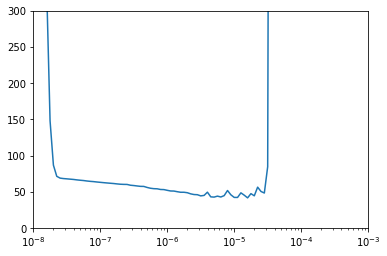

In [10]:
# 학습률에 따른 손실 정도. 이걸 보고 다시 학습을 시킨다. 
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [11]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9) # 앞서 본 학습률 대비 손실 정도 그래프를 보고 가장 낮은 손실값을 가지는 학습률을 확인한다. 그리고 이를 새로운 학습률로 정하고 다시 훈련을 시킨다. 
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

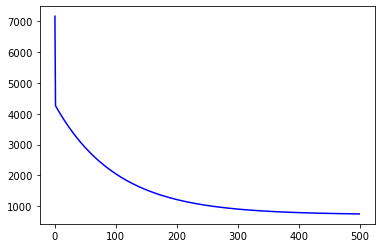

In [12]:
# 손실 그래프
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[3956.445556640625, 3924.625244140625, 3892.76513671875, 3861.45654296875, 3830.46435546875, 3799.572509765625, 3769.068359375, 3738.9052734375, 3709.000244140625, 3679.158203125, 3649.82373046875, 3620.935546875, 3592.208251953125, 3563.78369140625, 3535.50341796875, 3507.620849609375, 3479.862548828125, 3452.535888671875, 3425.403564453125, 3398.52685546875, 3372.0244140625, 3345.850830078125, 3319.904296875, 3294.24951171875, 3268.733154296875, 3243.68994140625, 3218.796142578125, 3194.01806640625, 3169.53076171875, 3145.29638671875, 3121.38525390625, 3097.716552734375, 3074.189697265625, 3050.938720703125, 3027.94384765625, 3005.110595703125, 2982.497314453125, 2960.038818359375, 2937.803955078125, 2915.874267578125, 2894.12890625, 2872.64990234375, 2851.5966796875, 2830.375732421875, 2809.588134765625, 2788.9306640625, 2768.525146484375, 2748.29638671875, 2728.148681640625, 2708.300048828125, 2688.590576171875, 2669.18896484375, 2649.92578125, 2631.078857421875, 2612.09716796875, 

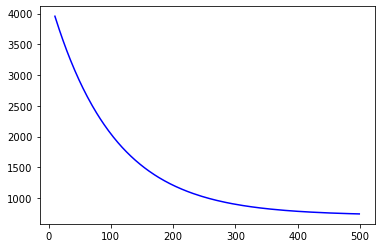

In [13]:
# Plot all but the first 10(처음 10개 빼고 다 보여주기)
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

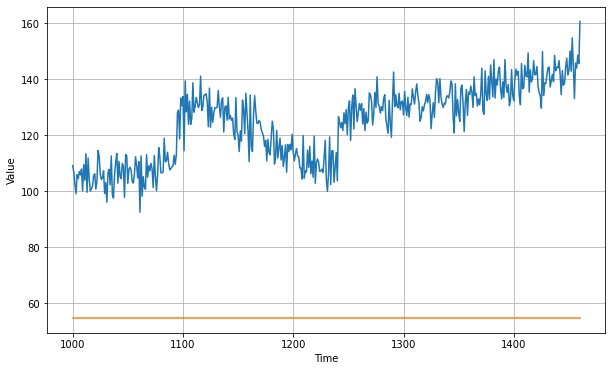

In [14]:
# 값 예측. 다 예측한 다음 검증 부분 예측값만 보여준다. 이를 실제값(검증 셋)과 비교
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results) # 왜 이렇게 나와

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

69.66373